In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from keras.utils import to_categorical
import keras
import keras_tuner
import sklearn
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D, Input
from keras import backend as K
from keras.callbacks import EarlyStopping


In [2]:
#Load in filepaths for each class
cardboard_files = glob.glob("Cardboard/*.s2p")
metal_files = glob.glob("Metal/*.s2p")
plastic_files = glob.glob("Plastic/*.s2p")
keras.utils.set_random_seed(42)

In [3]:
#Count how many scans have been taken from each object in given filename set
#Classes variable gives more naming control
def count_scans(filenames, classes):
    counts = []
    for c in classes:
        for i in range(34):
            x = sum(1 for name in filenames if name.__contains__(f'{c}o{i}s'))
            if x != 0:
                counts.append(x)
    return counts

In [4]:
#Method for loading in the dataset.
#Returns the dataset as a numpy array 
def dataset(filepaths):
    dataset = np.empty((len(filepaths), 101, 5))
    for index, file in enumerate(filepaths):
        data = np.loadtxt(file, skiprows = 1, usecols = (0,1,2,3,4))
        dataset[index] = data
    return dataset

In [5]:
#Combine files into single array and check the count
files = cardboard_files + metal_files + plastic_files
print(len(files))

#Get a combined scans array for later use
scans = count_scans(files, ["c", "m", "p"])

#Load in data, remove the frequency column and check shape
data = dataset(files)
data = np.delete(data, 0, 2)
data.shape

1112


(1112, 101, 4)

In [6]:
#Individual scan counts for creating ground truth vector
c_scans=count_scans(cardboard_files, ["c"])
p_scans=count_scans(plastic_files, ["p"])
m_scans=count_scans(metal_files, ["m"])

#Create ground truth vector
c_gt = np.zeros([sum(c_scans), 1])
m_gt = np.ones([sum(m_scans), 1])
p_gt = np.ones([sum(p_scans), 1])
p_gt[p_gt == 1] = 2
y = np.concatenate((c_gt, m_gt, p_gt))
y = to_categorical(y, num_classes=3)

y.shape


(1112, 3)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(data, y, test_size = 0.1, random_state = 2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2)


### Hyperparameter optimization

#### Trial 1

In [10]:
def build_model(hp):
    input_shape = (101, 4)
    m_type = hp.Int('type', min_value=1, max_value=4)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    if m_type == 1:
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))

    if m_type == 2:
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))

    if m_type == 3:
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(128, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))
        model.add(Dense(64, activation = 'relu'))

    if m_type == 4:
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(512, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        model.add(Dense(256, activation = 'relu'))
        
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [11]:
def build_model_testing(hp):
    input_shape = (101, 4)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    model.add(Dense(units=256, activation = 'relu'))
    model.add(Dense(units=256, activation = 'relu'))
    # Tune the number of layers    
    for i in range(hp.Int('num_layers', min_value=1, max_value=4)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                     min_value=64,
                                     max_value=128,
                                     step=64),
                        activation='relu'))
    model.add(Dense(units=32, activation = 'relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer=hp.Choice('optimizer', values=['adam', 'sgd']),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [12]:
from keras_tuner.tuners import GridSearch

Gtuner = GridSearch(
    build_model,
    objective='val_accuracy',
    executions_per_trial=1,
    directory = 'mk_trial1',
    project_name = 'mk_trial1'
)

Reloading Tuner from mk_trial1\mk_trial1\tuner0.json


In [13]:
Gtuner.search(X_train, y_train, epochs=400, validation_data=(X_val, y_val), verbose = 2)

In [14]:
Gtuner.results_summary()

Results summary
Results in mk_trial1\mk_trial1
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0000 summary
Hyperparameters:
type: 1
optimizer: adam
Score: 0.9399999976158142

Trial 0007 summary
Hyperparameters:
type: 4
optimizer: rmsprop
Score: 0.9100000262260437

Trial 0002 summary
Hyperparameters:
type: 2
optimizer: adam
Score: 0.8999999761581421

Trial 0001 summary
Hyperparameters:
type: 1
optimizer: rmsprop
Score: 0.8999999761581421

Trial 0003 summary
Hyperparameters:
type: 2
optimizer: rmsprop
Score: 0.8899999856948853

Trial 0004 summary
Hyperparameters:
type: 3
optimizer: adam
Score: 0.8799999952316284

Trial 0005 summary
Hyperparameters:
type: 3
optimizer: rmsprop
Score: 0.8799999952316284

Trial 0006 summary
Hyperparameters:
type: 4
optimizer: adam
Score: 0.8799999952316284


In [15]:
best_model = Gtuner.get_best_models(num_models=1)[0]
best_model.summary()

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 404)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,451 (251.76 KB)

 Trainable params: 64,451 (251.76 KB)

 Non-trainable params: 0 (0.00 B)

In [16]:
y_test_vals = np.argmax(y_test, axis=-1)
predictions = best_model.predict(X_test, verbose=0)
predictions = np.argmax(predictions, axis=-1)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])
#labels = ["True Neg","False Pos","False Neg","True Pos"]


Test set accuracy: 0.9553571343421936


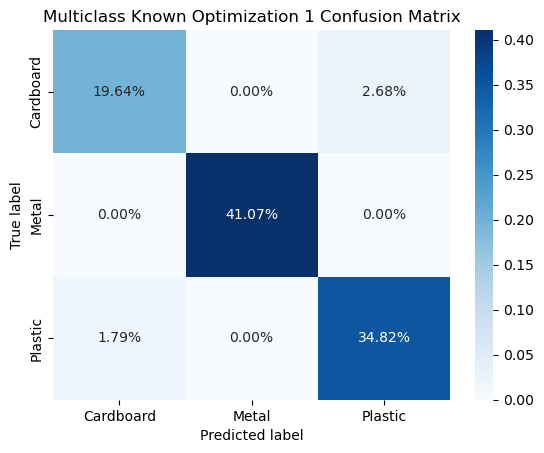

In [17]:
categories = ["Cardboard","Metal","Plastic"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test_vals, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Multiclass Known Optimization 1 Confusion Matrix')
plt.savefig('Graphs/Multiclass_Known_op_1.png')

#### Trial 2

In [19]:
def build_model_2(hp):
    input_shape = (101, 4)
    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    for i in range(hp.Int('num_large_layers', min_value=0, max_value=1)):
        model.add(Dense(256, activation = 'relu'))
    for i in range(hp.Int('num_mid_layers', min_value=1, max_value=2)):
        model.add(Dense(128, activation = 'relu'))
    for i in range(hp.Int('num_small_layers', min_value=1, max_value=3)):
        model.add(Dense(64, activation = 'relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [20]:
from keras_tuner.tuners import GridSearch

Gtuner = GridSearch(
    build_model_2,
    objective='val_accuracy',
    executions_per_trial=1,
    directory = 'mk_trial2',
    project_name = 'mk_trial2'
)

Reloading Tuner from mk_trial2\mk_trial2\tuner0.json


In [21]:
Gtuner.search(X_train, y_train, epochs=500, validation_data=(X_val, y_val), verbose = 2)

In [22]:
Gtuner.results_summary()

Results summary
Results in mk_trial2\mk_trial2
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0002 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 1
num_small_layers: 2
optimizer: adam
Score: 0.9300000071525574

Trial 0006 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 2
num_small_layers: 1
optimizer: adam
Score: 0.9200000166893005

Trial 0012 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 1
num_small_layers: 1
optimizer: adam
Score: 0.9200000166893005

Trial 0020 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 2
num_small_layers: 2
optimizer: adam
Score: 0.9200000166893005

Trial 0000 summary
Hyperparameters:
num_large_layers: 0
num_mid_layers: 1
num_small_layers: 1
optimizer: adam
Score: 0.9100000262260437

Trial 0016 summary
Hyperparameters:
num_large_layers: 1
num_mid_layers: 1
num_small_layers: 3
optimizer: adam
Score: 0.9100000262260437

Trial 0014 summary
Hyperparameters:
num_large_layers: 1
num

In [23]:
best_model = Gtuner.get_best_models(num_models=1)[0]
best_model.summary()

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 404)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        51,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 64,451 (251.76 KB)

 Trainable params: 64,451 (251.76 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
y_test_vals = np.argmax(y_test, axis=-1)
predictions = best_model.predict(X_test, verbose=0)
predictions = np.argmax(predictions, axis=-1)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])
#labels = ["True Neg","False Pos","False Neg","True Pos"]


Test set accuracy: 0.9464285969734192


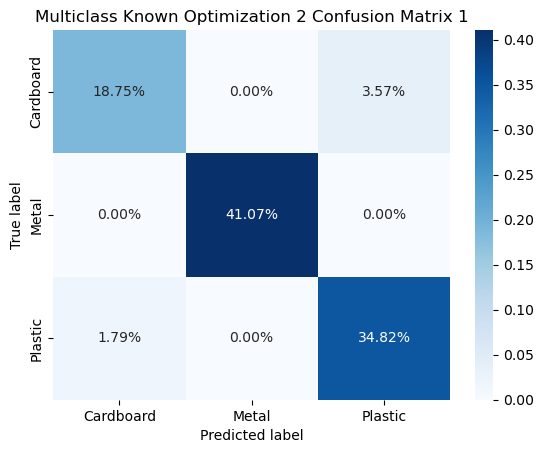

In [25]:
categories = ["Cardboard","Metal","Plastic"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test_vals, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Multiclass Known Optimization 2 Confusion Matrix 1')
plt.savefig('Graphs/Multiclass_Known_op_2_1.png')

In [26]:
best_model = Gtuner.get_best_models(num_models=2)[1]
predictions = best_model.predict(X_test, verbose=0)
predictions = np.argmax(predictions, axis=-1)

scores = best_model.evaluate(X_test, y_test, verbose=0)
print("Test set accuracy:", scores[1])

C:\Users\joona\anaconda3\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Test set accuracy: 0.9375


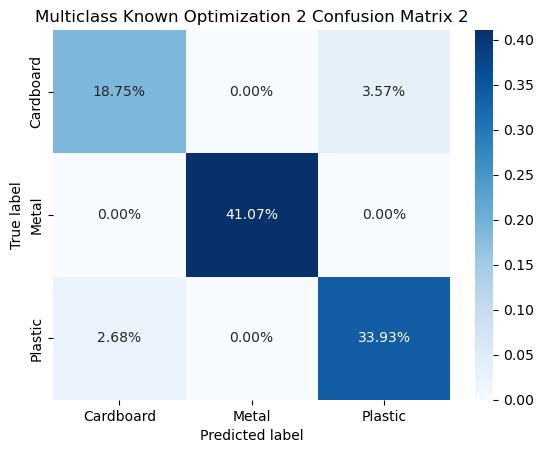

In [27]:
categories = ["Cardboard","Metal","Plastic"]
cf_matrix = sklearn.metrics.confusion_matrix(y_test_vals, predictions)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('Multiclass Known Optimization 2 Confusion Matrix 2')
plt.savefig('Graphs/Multiclass_Known_op_2_2.png')

### K-fold validation of previous models

In [29]:
initializer = keras.initializers.GlorotUniform(seed=42)

In [30]:
def build_k_fold_model():
    input_shape = (101, 4)
    nb_classes = 3

    model = Sequential()
    model.add(Input(shape=input_shape))
    model.add(Flatten())
    # Tune the number of layers    
    model.add(Dense(units=128 ,activation='relu', kernel_initializer = initializer))
    model.add(Dense(units=64, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(units=64, activation = 'relu', kernel_initializer = initializer))
    model.add(Dense(3, activation='softmax'))
    
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model


In [31]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath="model.keras",
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [32]:
from sklearn.model_selection import KFold

accuracy_per_fold = []
precision_per_fold = []
recall_per_fold = []
f1_per_fold = []
cf_matrices = []
kf = KFold(n_splits=10, shuffle=True, random_state=1)

for fold, (train_index, test_index) in enumerate(kf.split(data)):
    print(f'Fold {fold + 1}')

    X_train, X_test = data[train_index], data[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state = 2)

    model = build_k_fold_model()
    
    model.fit(X_train, y_train,
              epochs=500,
              batch_size=128,
              validation_data=(X_val, y_val),
              callbacks = [model_checkpoint_callback],
              verbose=0)

    
    model = keras.models.load_model("model.keras")

    predictions = np.argmax(model.predict(X_test), axis=1)
    accuracy = accuracy_score(np.argmax(y_test, axis=1), predictions)

    values = precision_recall_fscore_support(np.argmax(y_test, axis = 1), predictions, average='macro')
    cf_matrix = sklearn.metrics.confusion_matrix(np.argmax(y_test, axis = 1), predictions)


    accuracy_per_fold.append(accuracy)
    precision_per_fold.append(values[0])
    recall_per_fold.append(values[1])
    f1_per_fold.append(values[2])
    cf_matrices.append(cf_matrix)
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {values[0] * 100:.2f}%')
    print(f'Recall: {values[1] * 100:.2f}%')
    print(f'F1-score: {values[2]:.4f}')

average_accuracy = np.mean(accuracy_per_fold)
average_precision = np.mean(precision_per_fold)
average_recall = np.mean(recall_per_fold)
average_f1 = np.mean(f1_per_fold)
print(f'\nAverage Accuracy Across {10} Folds: {average_accuracy * 100:.2f}%')
print(f'\nAverage Precision Across {10} Folds: {average_precision * 100:.2f}%')
print(f'\nAverage Recall Across {10} Folds: {average_recall * 100:.2f}%')
print(f'\nAverage F1-score Across {10} Folds: {average_f1:.4f}')

Fold 1
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy: 91.07%
Precision: 91.06%
Recall: 91.84%
F1-score: 0.9118
Fold 2
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 90.18%
Precision: 90.31%
Recall: 89.85%
F1-score: 0.9004
Fold 3
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 90.99%
Precision: 91.13%
Recall: 90.73%
F1-score: 0.9075
Fold 4
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy: 92.79%
Precision: 93.78%
Recall: 92.34%
F1-score: 0.9285
Fold 5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
Accuracy: 94.59%
Precision: 94.57%
Recall: 94.82%
F1-score: 0.9451
Fold 6
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Accuracy: 99.10%
Precision: 99.19%
Recall: 98.96%
F1-score: 0.9906
Fold 7
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Accuracy: 92.79%
Precision: 92.45%
Recall: 92.20%
F1-score: 0.9227
Fold 8
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 93.69%
Precision: 93.53%
Recall: 93.53%
F1-score: 0.9343
Fold 9
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Accuracy: 97.30%
Precision: 97.44%
Recall: 97.37%
F1-score:

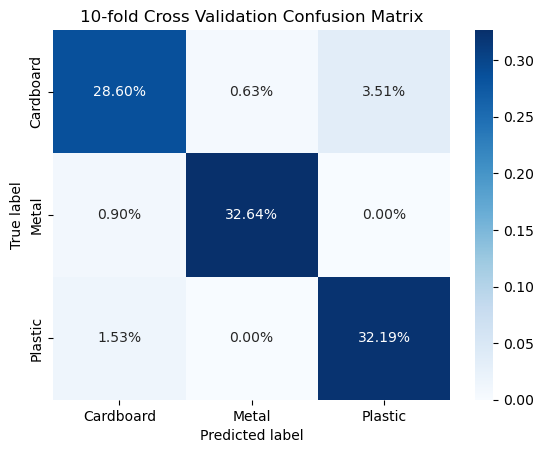

In [33]:
av_cf = sum(cf_matrices)
sns.heatmap(av_cf/np.sum(av_cf), annot=True, xticklabels=categories, yticklabels=categories,  
            fmt='.2%', cmap='Blues')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title('10-fold Cross Validation Confusion Matrix')
plt.savefig('Graphs/Multiclass_Known_k-fold.png')